##### Grading Feedback

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- Students are responsible for reading the usage comments and understanding how to properly use the get_training_filename() function.  Runtime errors which result from incorrect usage of get_training_filename() shall result in a  point reduction.  
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.  Heavy weight operations that convert data to pandas or spark (like collect()) will result in a point reduction.__

### Wine Analysis
I'm a big fan of wine and would love to use visualizations, machine learning, and inference to learn more about the characteristics of a good wine and predict good wines.  Unfortunately I'm too busy (and lazy) to do the analysis myself but I do have just under 60 trained data scientests at my disposal to do the research for me.  The data set contains the following columns:<br>

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [1]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Question 1 Data Wrangling: (10 pts)
Read the winequality-red.csv data set into a spark data frame named wine_df.  Use the get_training_filename function provided above to determine the appropriate file path based on the platform on which you are running. Check the resulting data frame for NA / NAN values and deal with these problems appropriately.  Note that the target variable has 10 classes.  Convert the 10 classes into 2 classes.  If the target variable is greater than or equal to 7, replace the label with a 1 indicating good wine.  If the target varible is less than 7, replace the label with a 0 indicating a lower quality wine.

In [2]:
wine_df = spark.read.csv(get_training_filename('winequality-red.csv'), header = True, inferSchema = True)

In [3]:
display(wine_df.toPandas().head())

print("Shape of wine_df:", (wine_df.count(), len(wine_df.columns)))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Shape of wine_df: (1599, 12)


In [4]:
from pyspark.sql.functions import *

print("NaN values in wine_df dataframe:")
display(wine_df.select([count(when(isnan(c), c)).alias(c) for c in wine_df.columns]).toPandas())

wine_df = wine_df.withColumn("quality", when(wine_df.quality >= 7, 1).otherwise(0))
wine_df = wine_df.withColumnRenamed("quality", "label")

NaN values in wine_df dataframe:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,0,0,0,0,0,0,0,0,0,0,0


##### Grading feedback cell

# Question 2 Visualizations (10 pts)
I am interested to know more about the data set.  Create one or more visualizations that summarize the data.  Write a short description that helps me understand the visualizations.  Tell me something interesting or surprising about the data.

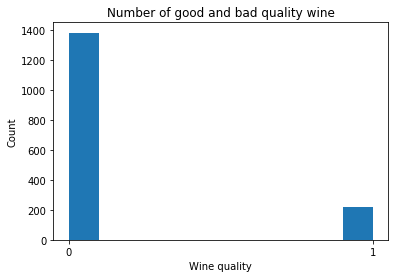

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(wine_df.rdd.map(lambda row: row.label).collect())
plt.xticks(range(0, 2))
plt.xlabel("Wine quality")
plt.ylabel("Count")
plt.title("Number of good and bad quality wine")

plt.show()

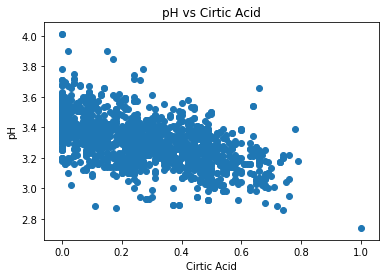

In [6]:
%matplotlib inline

plt.scatter(wine_df.select(col('citric acid')).collect(), wine_df.select(col('pH')).collect()) 
plt.xlabel("Cirtic Acid")
plt.ylabel("pH")
plt.title("pH vs Cirtic Acid")

plt.show()

Your short description here:<br>

- There are very few good quality wine.

- As citric acid content increases, pH decreases and wine will be more acidic.

##### Grading Feedback

# Random Forest

# Question 3: (10 pts)
Create a spark RandomForestClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train_df, test_df = wine_df.randomSplit([0.6, 0.4], seed = 13)

va = VectorAssembler().setInputCols(train_df.columns[:len(train_df.columns)-1]).setOutputCol('features')

rf = RandomForestClassifier()
rf_pipe = Pipeline(stages = [va, rf])
fitted_rf = rf_pipe.fit(train_df)

bce = BinaryClassificationEvaluator()

bce.evaluate(fitted_rf.transform(test_df))

0.8842845111093305

##### Grading Feedback

# Question 4: (10 pts)
Use spark RandomForestClassifier, ParamGridBuilder, and CrossValidator objects to perform a random forest grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default random forest model above.  You are free to choose any hyper parameters you want in your grid search.  You should be able to achieve an AUC score around / above 88%. 

In [8]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

rf_grid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [25, 40, 50])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

rf_cv = CrossValidator()\
    .setEstimator(rf_pipe)\
    .setEvaluator(bce)\
    .setEstimatorParamMaps(rf_grid)\
    .setNumFolds(3)

rf_fitted_cv = rf_cv.fit(train_df)

bce.evaluate(rf_fitted_cv.transform(test_df))

0.910192909280502

##### Grading Feedback

# Question 5 (10 pts)
Extract the cross validation AUC score and specific hyper parameters used from the grid search above.  Create a pandas dataframe where the first column is the grid parameter name and the 2nd colum is the grid parameter value.  Make the last row of the pandas data frame the resulting AUC score.  Print the pandas data frame.  Describe in words in the markdown cell below what specific parameters you used in your grid and what those parameters do in the model.  For example, if you specified impurity in your grid, describe what impurity does in the random forest.  Keep the descriptions brief and at a high level, I'm just trying to see if you understand the high level concept of what the tuning parameter does.

In [9]:
import pandas as pd

rf_hp = {'Grid Parameter': ['numTrees', 'maxDepth', 'AUC score'], 
      'Grid Parameter Value': [rf_fitted_cv.bestModel.stages[-1].getNumTrees, 
                               rf_fitted_cv.bestModel.stages[-1].getOrDefault('maxDepth'),
                               bce.evaluate(rf_fitted_cv.transform(train_df))]}

rf_hp_df = pd.DataFrame(rf_hp)

rf_hp_df

,Grid Parameter,Grid Parameter Value
0,numTrees,40.0
1,maxDepth,10.0
2,AUC score,1.0


Write your grid search parameter descriptions here:

- numTrees: number of trees to train

The best model above trains 40 different trees

- maxDepth: maximum depth of the tree

The trees in the best model have a depth of 10

##### Grading Feedback

# Question 6: 5 pts
Create a pandas dataframe containing 2 columns: `feature` and `importance`.  Load the feature column with the dataset feature names and the 2nd column with the feature importances as determined by the best model produced by the grid search above.  Sort the dataframe by `importance` in descending order. In the markdown cell, tell me the 3 features that are most important to predicting a good wine.

In [10]:
pd.DataFrame(list(zip(wine_df.columns[:len(wine_df.columns)-1], 
                      rf_fitted_cv.bestModel.stages[-1].featureImportances.toArray())),
             columns = ['feature', 'importance']).sort_values('importance', ascending = False)

,feature,importance
10,alcohol,0.179196
9,sulphates,0.135940
1,volatile acidity,0.124434
0,fixed acidity,0.098042
6,total sulfur dioxide,0.082136
7,density,0.081628
2,citric acid,0.064945
4,chlorides,0.064852
8,pH,0.059726
5,free sulfur dioxide,0.059172


Your feature importance comments here.

With respect to random forest classifier, the top three features that are most important in predictiing a good wine are:

1. alcohol

2. sulphates

3. volatile acidity

# Question 7:  10 pts.
Print any of the trees in the forest from the final model.  Copy the printed text to the tree printout markdown cell below and retain the same formatting and indentation as the printout so it's easy for the graders to view the data.  Add comments to the markdown cell below describing how the root node is split:  Describe 2 things in the markdown cells below.  1) What specific predictor variable is being split and what is the value that determines the left / right split.  2) The top level split indicates the most important predictor in the data set.  Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above. <br>

In [11]:
print(rf_fitted_cv.bestModel.stages[-1].trees[0].toDebugString)

DecisionTreeClassificationModel (uid=dtc_1484c45febf9) of depth 10 with 155 nodes
  If (feature 10 <= 11.55)
   If (feature 10 <= 10.45)
    If (feature 1 <= 0.385)
     If (feature 4 <= 0.07150000000000001)
      If (feature 8 <= 3.145)
       Predict: 0.0
      Else (feature 8 > 3.145)
       If (feature 1 <= 0.245)
        Predict: 0.0
       Else (feature 1 > 0.245)
        If (feature 9 <= 0.585)
         Predict: 0.0
        Else (feature 9 > 0.585)
         If (feature 7 <= 0.99679)
          If (feature 9 <= 0.705)
           Predict: 1.0
          Else (feature 9 > 0.705)
           Predict: 0.0
         Else (feature 7 > 0.99679)
          Predict: 1.0
     Else (feature 4 > 0.07150000000000001)
      If (feature 6 <= 10.5)
       Predict: 1.0
      Else (feature 6 > 10.5)
       If (feature 1 <= 0.365)
        Predict: 0.0
       Else (feature 1 > 0.365)
        If (feature 7 <= 0.998005)
         Predict: 0.0
        Else (feature 7 > 0.998005)
         If (feature 10 <= 9.

##### Grading Feedback

##### Grading Feedback

What specific predictor variable is being split and what is the value that determines the left / right split:

The predictor variable used for split at the root is 'alcohol'

The value that determines the left/right split is a value less than 11.55 for alcohol

##### Grading Feedback

Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above:

Since random forest randomly selects 'k' features from the total features for each tree and calculates information gain, the top level predictor in one tree might not be included in the random 'k' features selected for another tree. Hence, the top level predictor can be different.

##### Grading Feedback

# Question 8:  10 pts.
Create a spark GBTClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [12]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier()
gbt_pipe = Pipeline(stages = [va, gbt])
fitted_gbt = gbt_pipe.fit(train_df)

bce.evaluate(fitted_gbt.transform(test_df))

0.8755213764337859

##### Grading Feedback

# Question 9:  10 pts.
Use spark GBTClassifier, ParamGridBuilder, and CrossValidator objects to perform a GBT grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default GBT model and the random forest model above.  You are free to experiment with any search parameters you wish.  It is also okay to experiment with maxIter and stepSize outside of the grid if you wish as long as you comment what you are doing.

In [13]:
gbt_grid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [10, 15, 20])\
    .addGrid(gbt.featureSubsetStrategy, ['all', 'sqrt'])\
    .build()

gbt_cv = CrossValidator()\
    .setEstimator(gbt_pipe)\
    .setEvaluator(bce)\
    .setEstimatorParamMaps(gbt_grid)\
    .setNumFolds(3)

gbt_fitted_cv = gbt_cv.fit(train_df)

bce.evaluate(gbt_fitted_cv.transform(test_df))

0.8929072752065462

##### Grading Feedback

# Question 10 10 pts
Create a grid search summary pandas data frame for the GBT grid search exactly like you did in question 5 above.

In [14]:
gbt_hp = {'Grid Parameter': ['maxDepth', 'featureSubsetStrategy', 'AUC score'], 
      'Grid Parameter Value': [gbt_fitted_cv.bestModel.stages[-1].getOrDefault('maxDepth'),
                               gbt_fitted_cv.bestModel.stages[-1].getOrDefault('featureSubsetStrategy'),
                               bce.evaluate(gbt_fitted_cv.transform(train_df))]}

gbt_hp_df = pd.DataFrame(gbt_hp)

gbt_hp_df

,Grid Parameter,Grid Parameter Value
0,maxDepth,15
1,featureSubsetStrategy,sqrt
2,AUC score,1


##### Grading Feedback

Add search parameter comments here

- maxDepth: maximum depth of the tree

The trees in the best model have a depth of 15

- featureSubsetStrategy: number of features to consider for split at each tree node

The trees in the best model consider square root of number of features for split at each node

# Question 11 (5 pts):
Create and print a pandas dataframe with the columns `feature` and `importance` just like question 6 above.  Also, compare the feature importances to random forest from question 6 above - how different or similar are the feature importances between GBT and random forest.

In [15]:
pd.DataFrame(list(zip(wine_df.columns[:len(wine_df.columns)-1], 
                      gbt_fitted_cv.bestModel.stages[-1].featureImportances.toArray())),
             columns = ['feature', 'importance']).sort_values('importance', ascending = False)

,feature,importance
10,alcohol,0.187793
1,volatile acidity,0.128978
9,sulphates,0.127968
6,total sulfur dioxide,0.092700
0,fixed acidity,0.091003
7,density,0.074852
5,free sulfur dioxide,0.068679
2,citric acid,0.065506
4,chlorides,0.057196
3,residual sugar,0.055782


Feature importance comments here:

With respect to GBT classifier, the top three features that are most important in predictiing a good wine are:

1. alcohol

2. volatile acidity

3. sulphates

Add feature importance comparison comments here:<br>

Top three features that are most important are same in both Random Forest and GBT. 

'alcohol' has highest importance in GBT and Random Forest.

'sulphates' has the second highest importance in Random Forest and third highest importance in GBT.

'volatile acidity' has second highest importance in GBT while third highest importance in Random Forest.

##### Grading Feedback